# CoVid 19 - Prediction using VAR model

****The objective of this notebook is to generate a time series model using VAR to predict the confirmed ,samples tested and positive cases for each state for the upcoming days.****

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import folium
import seaborn as sns

In [3]:
df = pd.read_csv('/kaggle/input/covid19-in-india/covid_19_india.csv')
df.head()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,1,30/01/20,6:00 PM,Kerala,1,0,0,0,1
1,2,31/01/20,6:00 PM,Kerala,1,0,0,0,1
2,3,01/02/20,6:00 PM,Kerala,2,0,0,0,2
3,4,02/02/20,6:00 PM,Kerala,3,0,0,0,3
4,5,03/02/20,6:00 PM,Kerala,3,0,0,0,3


## Data Wrangling

In [4]:
df = df.dropna()

In [5]:
df = df.replace({'Telangana':'Telengana'})

Date and time conversion to make the dataset as a time-series data

In [6]:
df['Date'] = pd.to_datetime(df.Date,dayfirst=True).dt.strftime('%Y-%m-%d')
df['Time'] = pd.to_datetime(df['Time']).dt.strftime('%H:%M:%S')
df.tail()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
4456,4457,2020-07-24,08:00:00,Telengana,-,-,39327,447,50826
4457,4458,2020-07-24,08:00:00,Tripura,-,-,2072,10,3656
4458,4459,2020-07-24,08:00:00,Uttarakhand,-,-,3399,60,5445
4459,4460,2020-07-24,08:00:00,Uttar Pradesh,-,-,35803,1289,58104
4460,4461,2020-07-24,08:00:00,West Bengal,-,-,31656,1255,51757


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4461 entries, 0 to 4460
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Sno                       4461 non-null   int64 
 1   Date                      4461 non-null   object
 2   Time                      4461 non-null   object
 3   State/UnionTerritory      4461 non-null   object
 4   ConfirmedIndianNational   4461 non-null   object
 5   ConfirmedForeignNational  4461 non-null   object
 6   Cured                     4461 non-null   int64 
 7   Deaths                    4461 non-null   int64 
 8   Confirmed                 4461 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 348.5+ KB


In [8]:
df = df.loc[df['State/UnionTerritory'] != 'Unassigned']
df = df.loc[df['State/UnionTerritory'] != 'Cases being reassigned to states']

## Numerical variable dependency

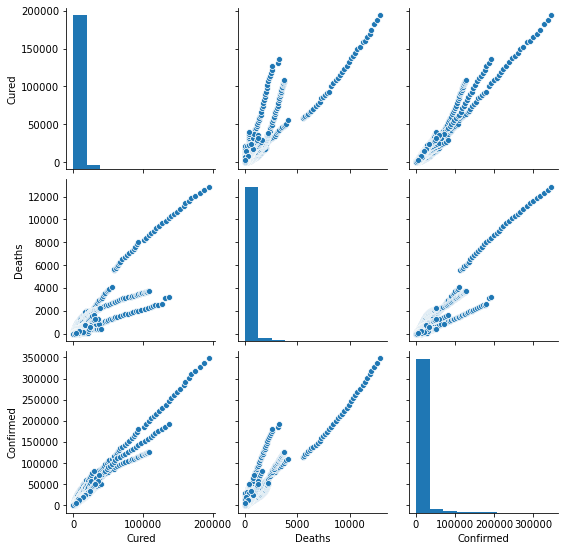

In [9]:
df_train = df[['ConfirmedIndianNational','ConfirmedForeignNational','Cured','Deaths','Confirmed']]
sns.pairplot(df_train)

Based on the graph, the rate of curing a person will be more when compared to the rate of deaths caused in a state. Likewise, the rate of confirmed cases will be increasing more than the rate at which the persons are cured.

Since the recent count of the cases is recorded on the current date. The last record of each dataset is considered for visualisation

In [10]:
df_u = df['State/UnionTerritory'].unique()
df3 = pd.DataFrame()
for s in (df_u):
                l = df.loc[df['State/UnionTerritory'] == s]
                l1= l['Sno'].idxmax(axis=1)
                l2 = l.loc[l.index == l1]
                df3 = df3.append([l2])
df3.head()                                            
                                           
                                                                

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
4442,4443,2020-07-24,08:00:00,Kerala,-,-,6594,50,16110
4456,4457,2020-07-24,08:00:00,Telengana,-,-,39327,447,50826
4434,4435,2020-07-24,08:00:00,Delhi,-,-,109065,3745,127364
4453,4454,2020-07-24,08:00:00,Rajasthan,-,-,23815,594,33220
4459,4460,2020-07-24,08:00:00,Uttar Pradesh,-,-,35803,1289,58104


In [11]:
df3 = df3.reset_index()
df3 = df3.drop(columns=['index','Sno'])
df3 = df3[['State/UnionTerritory','Confirmed','Deaths','Cured']]
df3 = df3.loc[df3['State/UnionTerritory'] != 'Unassigned']
df3 = df3.loc[df3['State/UnionTerritory'] != 'Cases being reassigned to states']
df3.head()

,State/UnionTerritory,Confirmed,Deaths,Cured
0,Kerala,16110,50,6594
1,Telengana,50826,447,39327
2,Delhi,127364,3745,109065
3,Rajasthan,33220,594,23815
4,Uttar Pradesh,58104,1289,35803


Calculation of the total cases in each state

In [12]:
df3['Total Cases'] = (df3['Confirmed'] + df3['Deaths'] + df3['Cured']).astype(int)
df3.head()


,State/UnionTerritory,Confirmed,Deaths,Cured,Total Cases
0,Kerala,16110,50,6594,22754
1,Telengana,50826,447,39327,90600
2,Delhi,127364,3745,109065,240174
3,Rajasthan,33220,594,23815,57629
4,Uttar Pradesh,58104,1289,35803,95196


## Total cases in each state in India

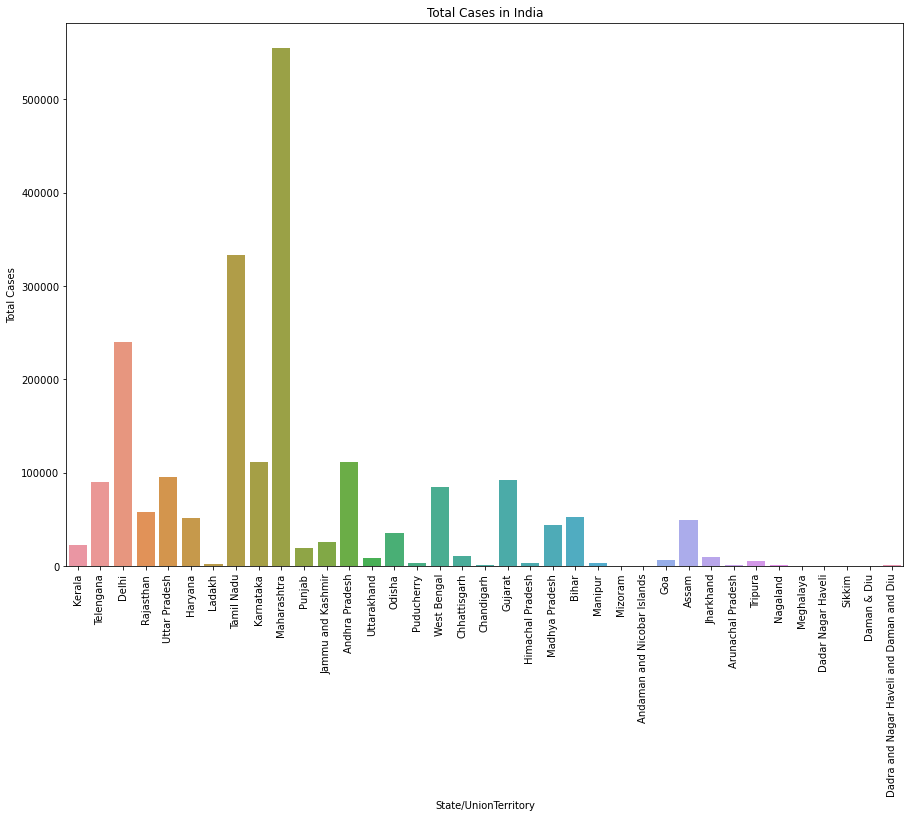

In [13]:
cols = df3[['State/UnionTerritory','Total Cases']]
states = np.asarray(df3['State/UnionTerritory'])
plt.figure(figsize=(15,10))
p = sns.barplot(x=df3['State/UnionTerritory'],y=df3['Total Cases'])
p.set_xticklabels(labels=states,rotation=90)
plt.title('Total Cases in India');

From the graph, Delhi,TN,Maharashtra and Gujarat are having more than 1L cases till date. While other states have minimal cases.

## Rate of increase in confirmed cases based on Date

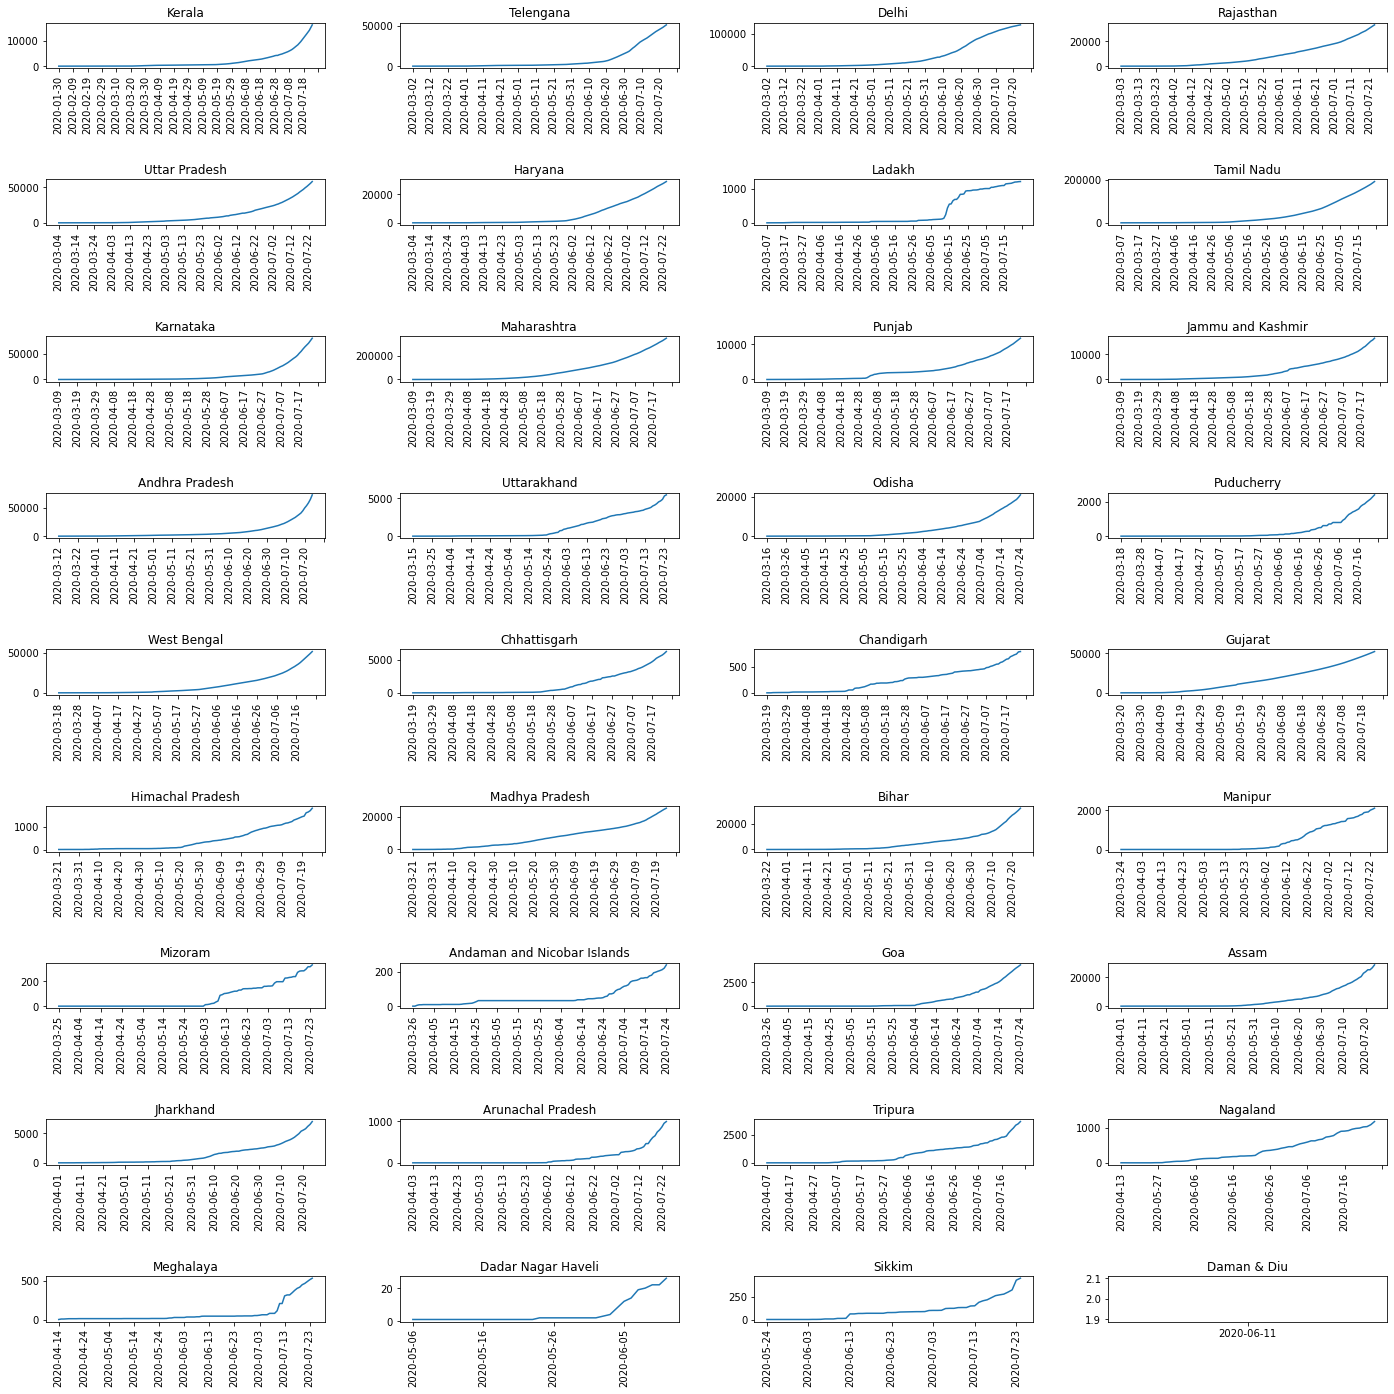

In [14]:
import matplotlib.ticker as ticker
fig =plt.figure(figsize=(20,20));
for i,j in zip(df_u,range(1,len(df_u))):
                                                                        g = df.loc[df['State/UnionTerritory']==i]
                                                                        x = g['Date']
                                                                        y = g['Confirmed']
                                                                        ax = plt.subplot(9,4,j)
                                                                        ax.plot(x,y)
                                                                        plt.xticks(rotation=90)
                                                                        plt.title(i)
                                                                        fig.tight_layout(pad=3.0)
                                                                        ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
                                                                        

The above graph is a time-series graph depicting the confirmed cases until date. Most of the states have a steady / exponential increase in the number of confirmed cases. 

## Samples Tested

In [15]:
df_testing = pd.read_csv('/kaggle/input/covid19-in-india/StatewiseTestingDetails.csv')
df_testing = df_testing.fillna(0)
df_testing['Date'] = pd.to_datetime(df_testing['Date']).dt.strftime('%Y-%m-%d')
df_testing.head()

,Date,State,TotalSamples,Negative,Positive
0,2020-04-17,Andaman and Nicobar Islands,1403.0,1210,12.0
1,2020-04-24,Andaman and Nicobar Islands,2679.0,0,27.0
2,2020-04-27,Andaman and Nicobar Islands,2848.0,0,33.0
3,2020-05-01,Andaman and Nicobar Islands,3754.0,0,33.0
4,2020-05-16,Andaman and Nicobar Islands,6677.0,0,33.0


## Total samples collected everyday in each state

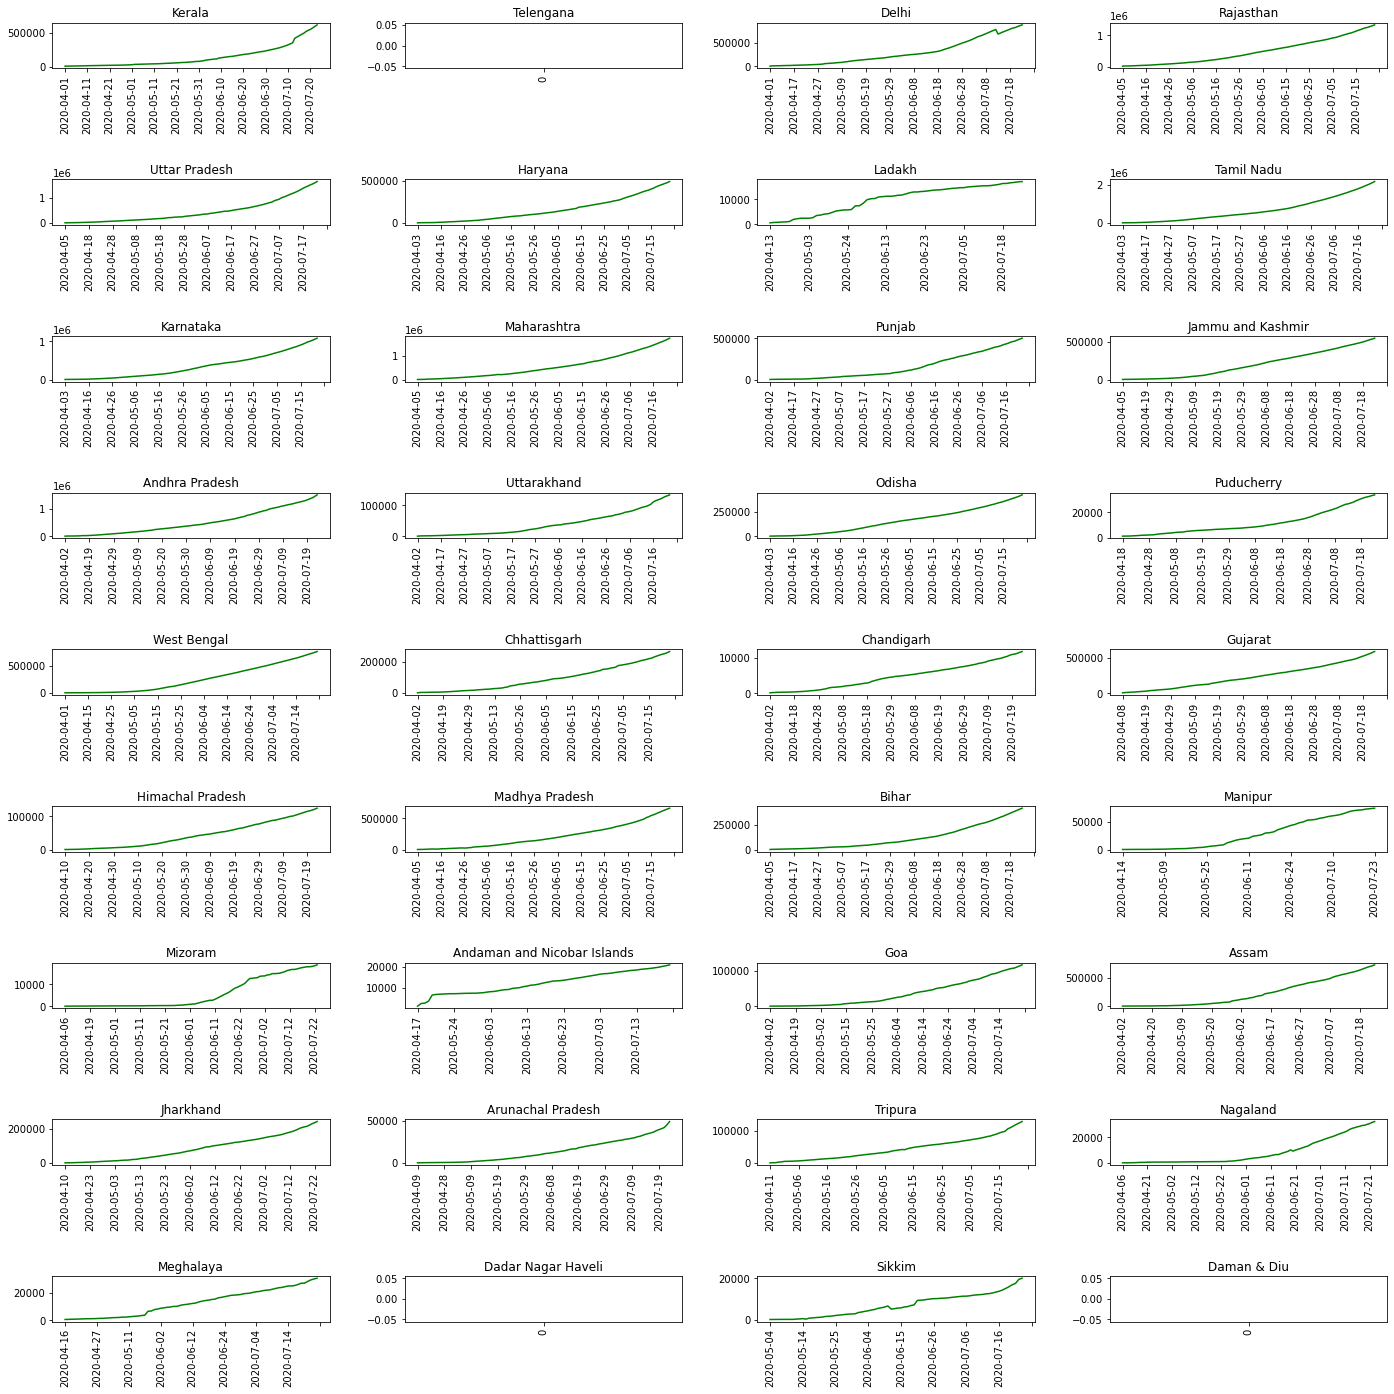

In [16]:
fig =plt.figure(figsize=(20,20))

for i,j in zip(df_u,range(1,len(df_u))):        
                                                                        g = df_testing.loc[df_testing['State']==i]
                                                                        x = g['Date']
                                                                        y = g['TotalSamples']
                                                                        ax = plt.subplot(9,4,j)
                                                                        ax.plot(x,y,color='green')
                                                                        plt.xticks(rotation=90)
                                                                        plt.title(i)
                                                                        fig.tight_layout(pad=3.0)
                                                                        ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
                                                                        
                                                                        

The sample collection rate in most of the states on an every day basis is increasing exponentially. However, this feature will be suitable for prediction only if 87% of the samples get tested and are categorised as 'positive' or 'negative'. For some states, the sample collection rate is less and hence, it would be difficult to predict the testing rate using the ML model.

## Positive cases tested everyday in each state

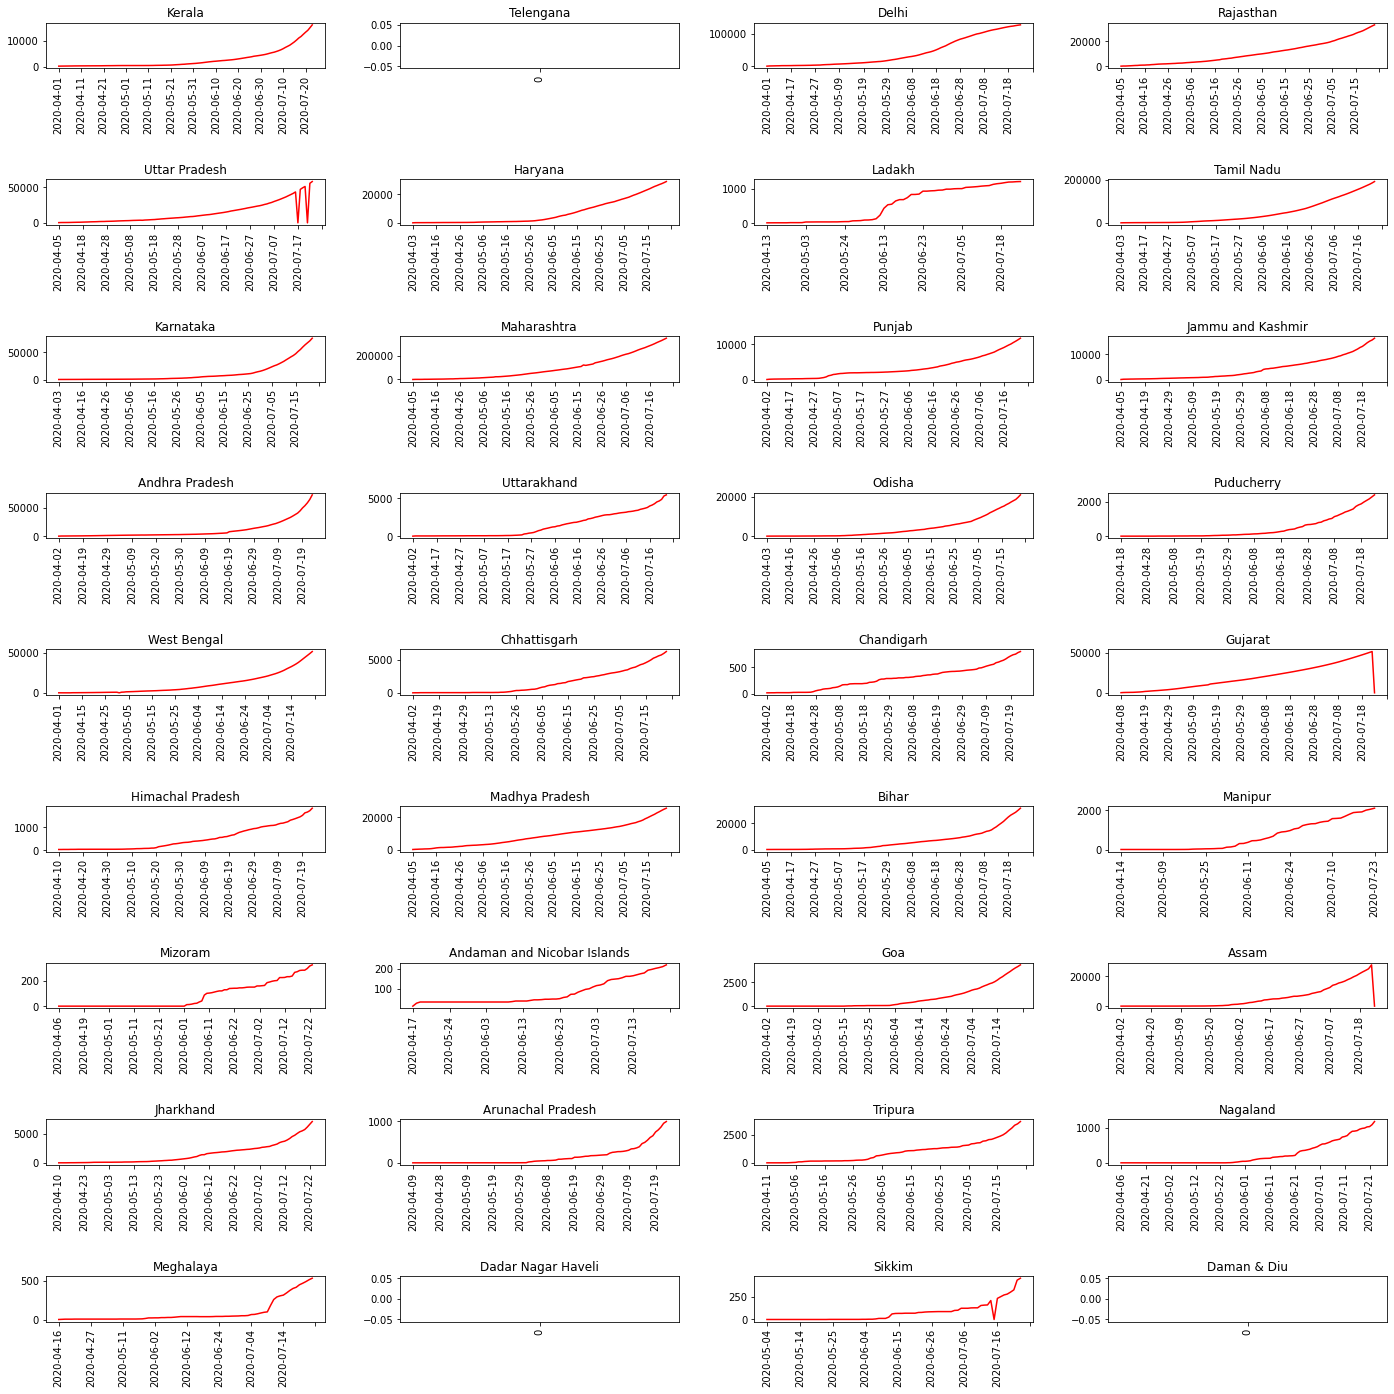

In [17]:
fig =plt.figure(figsize=(20,20))

for i,j in zip(df_u,range(1,len(df_u))):        
                                                                        g = df_testing.loc[df_testing['State']==i]
                                                                        x = g['Date']
                                                                        y = g['Positive']
                                                                        ax = plt.subplot(9,4,j)
                                                                        ax.plot(x,y,color='red')
                                                                        plt.xticks(rotation=90)
                                                                        plt.title(i)
                                                                        fig.tight_layout(pad=3.0)
                                                                        ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
                                                                        

For every state, the number of samples tested provides a considerable percentage of positive cases. For example, in case of TN, out of 6lakh samples, 5% of the samples were positive. On the other hand, some states have a constant positive case rate which means there were no positive cases for few days.

An inference from the above observations is that testing samples on a daily basis has certainly helped in detecting a considerable amount of positive cases. 

## Merging testing details with the main covid-19 dataset

This merging is done to build a model that will predict the covid 19 cases based on the samples tested and positive/ negative cases observed everyday.

In [18]:
df4 = pd.DataFrame(columns=[])
for i in df_u:
            state = df.loc[df['State/UnionTerritory'] == i]
            state1 = df_testing.loc[df_testing['State'] == i]
            
            for j in state['Date']:
                                        t = state1.loc[state1['Date'] == j]
                                        t1 = state.loc[state['Date'] == j]
                                        df4 = df4.append(t1.merge(t,how='outer',on=['Date']))

                                       
                             

In [19]:
df4 = df4.drop(columns=['Time','ConfirmedIndianNational','ConfirmedForeignNational','State'],axis=1)
df4 = df4.fillna(0)
df4 = df4.reset_index()
df4 = df4.drop(columns = ['index','Sno'],axis=1)
df4

,Date,State/UnionTerritory,Cured,Deaths,Confirmed,TotalSamples,Negative,Positive
0,2020-01-30,Kerala,0,0,1,0.0,0,0.0
1,2020-01-31,Kerala,0,0,1,0.0,0,0.0
2,2020-02-01,Kerala,0,0,2,0.0,0,0.0
3,2020-02-02,Kerala,0,0,3,0.0,0,0.0
4,2020-02-03,Kerala,0,0,3,0.0,0,0.0
...,...,...,...,...,...,...,...,...
4394,2020-07-20,Dadra and Nagar Haveli and Daman and Diu,414,2,605,38880.0,37789,705.0
4395,2020-07-21,Dadra and Nagar Haveli and Daman and Diu,448,2,684,39199.0,38022,733.0
4396,2020-07-22,Dadra and Nagar Haveli and Daman and Diu,463,2,705,0.0,0,0.0
4397,2020-07-23,Dadra and Nagar Haveli and Daman and Diu,474,2,733,0.0,0,0.0


## Correlation between the numerical parameters

In [20]:
coff = df4.corr()
coff[['Confirmed']]

,Confirmed
Cured,0.984371
Deaths,0.942281
Confirmed,1.000000
TotalSamples,0.719088
Positive,0.956802


Based on the correlation coefficient, it is best to use Total samples, Positive and Negative features as independant variables. While cured and death feature provides the perfect correlation coefficient, it can't be used in predicting the confirmed cases since those two features are dependent on the latter.

## Model Development

Since the dataset is a time-series data, Vector Auto Regression (VAR) is used for future forecasting. VAR model is used due to multiple features that needs to be predicted such as Confirmed,Total samples tested, positive and negative cases.

In [21]:
from sklearn.utils import shuffle
df5 = shuffle(df4)
df5 = df5.reset_index()
df5= df5.drop(columns=['index'],axis=1)
df5 = df5.sort_values(by='Date')
df5

,Date,State/UnionTerritory,Cured,Deaths,Confirmed,TotalSamples,Negative,Positive
798,2020-01-30,Kerala,0,0,1,0.0,0,0.0
3617,2020-01-31,Kerala,0,0,1,0.0,0,0.0
1016,2020-02-01,Kerala,0,0,2,0.0,0,0.0
2658,2020-02-02,Kerala,0,0,3,0.0,0,0.0
1318,2020-02-03,Kerala,0,0,3,0.0,0,0.0
...,...,...,...,...,...,...,...,...
4220,2020-07-24,Chhattisgarh,4377,30,6254,0.0,0,0.0
2482,2020-07-24,Tripura,2072,10,3656,0.0,0,0.0
814,2020-07-24,Bihar,20769,217,31980,0.0,0,0.0
291,2020-07-24,Assam,20699,70,28791,0.0,0,0.0


## Prediction using VAR Model

Before training the model, johansen test is performed to inspect the stationarity of the dataset.After the test, all the eigen values for the respective features are less than 1. Hence, the dataset is stationary and no further differncing/intergration is required.

Further, the VAR model is trained with the data of a single state and the same is used to predict the cases for the upcoming days.

The below model is an interactive one where the user can provide the state and number of days of prediction required. Though, the model can predict for n number of days, it is hard to represent the large data in the graph. Hence, a maximum of 10 to 20 days can be sent as input for a better visualisation.

***Note***: Telengana,Daman&Diu,Dadar and Nagar Haveli has no testing sample data. Hence, forecast is not predicted for these states alone. Also, for few states, the number of samples tested is zero. Hence, the Johansen test will fail and predictions cant be made.

In [22]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
@interact
def forecast_model(State = df_u,days = 5):
                                df6 = df5.loc[df5['State/UnionTerritory'] == State]
                                df6 = df6[['Date','Confirmed','TotalSamples','Positive']]
                                df6.index = df6['Date']
                                df6 = df6.drop(columns=['Date'])
                                df6_upd = df6.loc[df6.index != df6.index.max()]
                                
                        # Fit the exisiting data trends to the forecast model
                                from statsmodels.tsa.vector_ar.vecm import coint_johansen
                                jtest = coint_johansen(df6_upd,1,1);
                                from statsmodels.tsa.vector_ar.var_model import VAR
                                m = VAR(df6_upd);
                                model = m.fit();
                            #    ax = model.plot();
                             #   ax.tight_layout(pad=3.0)
                       # predict the model         
                                valid_pred = model.forecast(model.y,steps=days);
                             #   ax = model.plot_forecast(days);
                            #    ax.tight_layout(pad=3.0)
                                df7 = pd.DataFrame(valid_pred.round(0),columns=[['Confirmed','TotalSamples','Positive']])
                                df7.index = pd.date_range(df6.index.max(),periods=days);
                                
                       #plot predictions         
                                plt.figure(figsize=(10,5))

                                plt.subplot(1,2,1)
                                plt.plot(df7[['Confirmed']],color='red')
                                plt.xticks(df7.index,rotation=90)
                                plt.tight_layout(pad=7.0)
                                plt.title('Confirmed cases')
                                plt.subplot(1,2,2)
                                plt.plot(df7[['TotalSamples']])
                                plt.xticks(df7.index,rotation=90)
                                plt.title('Total Samples to be tested')
                                return df7
                                

interactive(children=(Dropdown(description='State', options=('Kerala', 'Telengana', 'Delhi', 'Rajasthan', 'Utt…

**The interactive model will run only when Kernal is active**

In [23]:
df8 = pd.DataFrame(columns=[['State','Confirmed','TotalSamples','Positive']])
df10 = pd.DataFrame()
df_f = pd.DataFrame()
for i in df_u:
                                df9 = df5.loc[df5['State/UnionTerritory'] == i]
                                df9 = df9[['Date','Confirmed','TotalSamples','Positive']]
                                df9.index = df9['Date']
                                df9 = df9.drop(columns=['Date'])
                                df9_upd = df9.loc[df9.index != df9.index.max()]
                                
                        # Fit the exisiting data trends to the forecast model
                                if i != 'Daman & Diu':
                                                                                
                                                                                    from statsmodels.tsa.vector_ar.var_model import VAR
                                                                                    m = VAR(df9_upd) 
                                                                                    model = m.fit()
                                                                               # predict the model         
                                                                                    valid_pred = model.forecast(model.y,steps=10);
                                                                                    df8 = pd.DataFrame(valid_pred.round(0))
                                                                                    df8.index = pd.date_range(df9.index.max(),periods=10);
                                                                                    for j in range(len(df8)):
                                                                                                                df10 = df10.append([i])
                                                                                    df10.index = pd.date_range(df9.index.max(),periods=10);
                                                                                    df_f = df_f.append(df10.merge(df8,how='outer',on=df10.index))
                                                                                    df10 = pd.DataFrame()
                                                        
                                

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/sta

In [24]:
df_forecast = df_f
df_forecast.columns=[['Date','State','Confirmed','TotalSamples','Positive']]
df_forecast = df_forecast.reset_index()
df_forecast = df_forecast.drop(columns=['index'],axis=1);
df_forecast

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,Date,State,Confirmed,TotalSamples,Positive
0,2020-07-24,Kerala,16117.0,641846.0,17266.0
1,2020-07-25,Kerala,17288.0,673451.0,18520.0
2,2020-07-26,Kerala,18556.0,707245.0,19884.0
3,2020-07-27,Kerala,19933.0,743411.0,21369.0
4,2020-07-28,Kerala,21431.0,782153.0,22986.0
...,...,...,...,...,...
355,2020-07-29,Dadra and Nagar Haveli and Daman and Diu,794.0,-8286.0,-141.0
356,2020-07-30,Dadra and Nagar Haveli and Daman and Diu,802.0,-9661.0,-162.0
357,2020-07-31,Dadra and Nagar Haveli and Daman and Diu,810.0,-10988.0,-183.0
358,2020-08-01,Dadra and Nagar Haveli and Daman and Diu,817.0,-12267.0,-204.0


In [32]:
df_forecast.to_csv('/kaggle/working/forecast.csv')
out = pd.read_csv('/kaggle/working/forecast.csv')
out.head()

,Unnamed: 0,Date,State,Confirmed,TotalSamples,Positive
0,0,2020-07-24,Kerala,16117.0,641846.0,17266.0
1,1,2020-07-25,Kerala,17288.0,673451.0,18520.0
2,2,2020-07-26,Kerala,18556.0,707245.0,19884.0
3,3,2020-07-27,Kerala,19933.0,743411.0,21369.0
4,4,2020-07-28,Kerala,21431.0,782153.0,22986.0


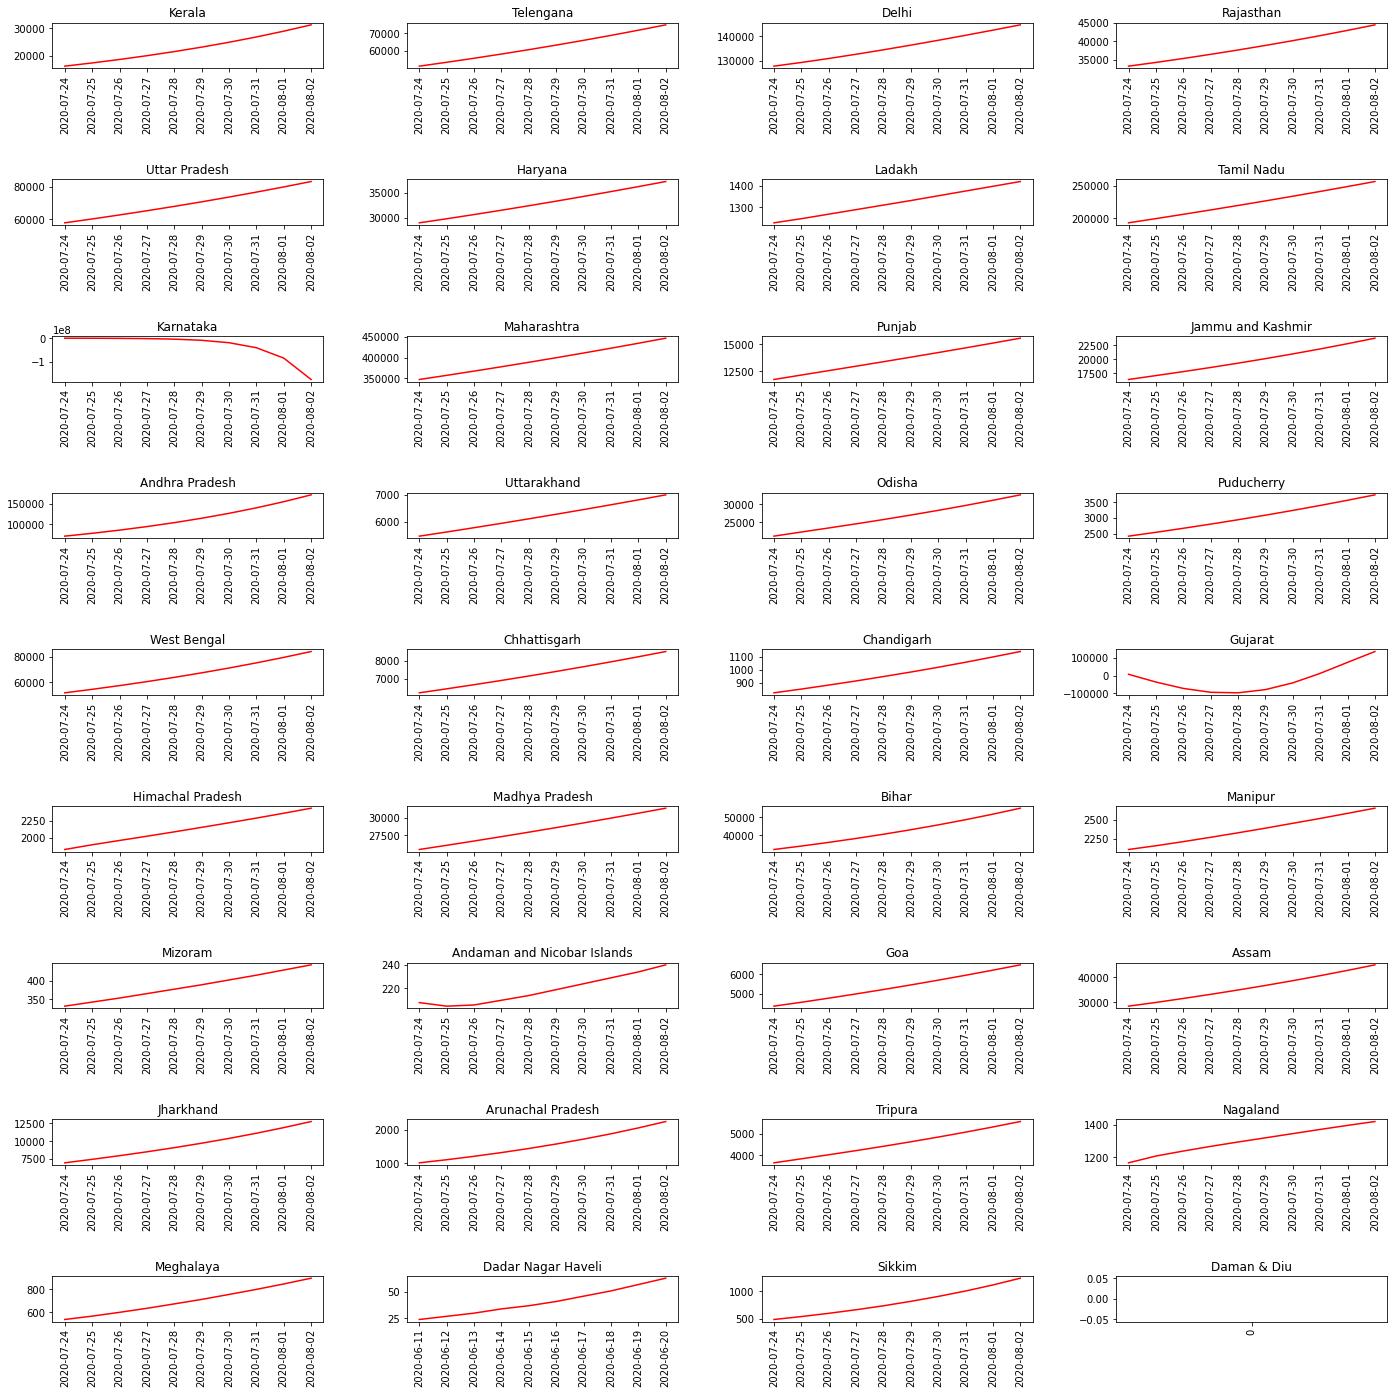

In [54]:
fig =plt.figure(figsize=(20,20))

for i,j in zip(df_u,range(1,len(df_u))):        
                                                                        g = out.loc[out['State']==i]
                                                                        x = g['Date']
                                                                        y = g['Confirmed']
                                                                        ax = plt.subplot(9,4,j)
                                                                        ax.plot(x,y,color='red')
                                                                        plt.xticks(rotation=90)
                                                                        plt.title(i)
                                                                        fig.tight_layout(pad=3.0)
                                                                        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
                                                                        

From the forecast model, it is understood that in the forthcoming week, most of the states have a steady increase in confirmed cases. While few states such as Karnataka shows a steep decline in the cases. Gujarat shows a decrease in initial days but it increases steadily after 2 days.

In [27]:
df2 = pd.read_csv('/kaggle/input/states/states.csv')
df2.head()

,Sno,State,Latitude,Longitude
0,1,Sikkim,27.703,88.15
1,2,Uttarakhand,30.376,79.97
2,3,Arunachal Pradesh,27.515,92.32
3,4,Himachal Pradesh,31.884,78.74
4,5,Nagaland,25.742,95.03


## Interactive Map Viz using Folium

The interact mode works only when Kernal is active. The purpose is to view different count for each of the dates for which the forecast has been done.

In [50]:
import folium
ind_map = folium.Map(location=(20,78),zoom_state=2)
@interact
def map_view(Date=out['Date']):
                    for i in df2['State']:
                                            d = out.loc[out['State'] == i]
                                            d1 = df2.loc[df2['State'] == i]
                                            d2 = d.loc[d['Date'] == Date]

                                            label = folium.Popup('Date:'+ str(Date) + ',' + str(d2[['Confirmed']]) + ','+ str(d2[['Positive']]), parse_html=True)
                                         
                                            folium.Marker(
                                                    [d1['Latitude'],d1['Longitude']],
                                                    radius=10,
                                                    popup=label,
                                                    fill=True,
                                                    fill_opacity=0.7).add_to(ind_map)
                    return ind_map




interactive(children=(Dropdown(description='Date', options=('2020-07-24', '2020-07-25', '2020-07-26', '2020-07…

## Inference

Most of the states have a steady increase in the cases for this particular week. With better testing rates, the confirmed cases are identified more easily.